In [1]:
from pathlib import Path
from typing import Dict, List, Union, Iterable, Tuple  
import json
import pandas as pd
pd.set_option('display.max_columns', None)
def load_parquet_dict(data_folder: str) -> dict[str, pd.DataFrame]:
    p = Path(data_folder)
    with open(p / "_dtype_book.json", "r", encoding="utf-8") as f:
        book = json.load(f)

    out = {}
    for fp in sorted(p.glob("*.parquet")):
        if fp.name.startswith("_"):
            continue
        name = fp.stem
        df = pd.read_parquet(fp)
        spec = book.get(name)
        if spec:
            df = df.astype(spec)
        else:
            raise Exception(f"{name} in dtype_book.json is {spec}")
        out[name.lower()] = df
    return out

dfs = load_parquet_dict("data/cleaned_result")
dfs

{'tasks':           TASK_KEY  REVISION    CREATEDBY         TIMECREATED  \
 0              NaN       NaN         None                 NaT   
 1              NaN       NaN         None                 NaT   
 2              NaN       NaN         None                 NaT   
 3              NaN       NaN         None                 NaT   
 4              NaN       NaN         None                 NaT   
 ...            ...       ...          ...                 ...   
 9957666  1656805.0     501.0  Integration 2014-02-06 10:46:12   
 9957667  1536581.0    1306.0  Integration 2012-07-23 09:05:42   
 9957668  1210121.0     457.0  Integration 2012-07-01 20:38:41   
 9957669  1428574.0     367.0  Integration 2014-08-25 15:38:55   
 9957670   569315.0     765.0  Integration 2012-12-12 16:10:14   
 
                MODIFIEDBY        TIMEMODIFIED              CALLID  TASKNUMBER  \
 0                    None                 NaT                None         NaN   
 1                    None       

In [2]:
## Can Use polars now
# import polars as pl
# pl.Config.set_tbl_cols(-1)
# tasks_df = pl.from_pandas(dfs["tasks"])
# tasks_df.columns

### - How long does each type of work typically take?

Here’s a recap of what we discussed in our previous meeting.
1. Work Analysis
Duration by Work Type
- How long does each type of work typically take?
Potential System Gaming
- Are there instances where work is completed unusually fast?
- Could crews be performing the work and logging it later, affecting reported duration?
Impact on Actual Duration
- How does this behavior influence the accuracy of recorded durations?
Duration Expectations
- What should be the standard or expected duration for each type of work?
Distribution and Outliers
- What percentage of work falls within the expected duration?
- What do the outliers suggest—are they anomalies, errors, or signs of inefficiency?

Planned vs. Actual Duration
- How closely does actual duration align with what was planned?
2. Scheduling Effectiveness
Crew Scheduling
- Are we assigning work to crews in a balanced and efficient way?
Workload Appropriateness
- Are crews receiving the right amount of work—too much, too little, or just right?
Schedule Feasibility
- Is the schedule realistic and achievable given current resources and constraints?
3. Operational Efficiency
Planned vs. Completed Work
- Does the work completed match what was planned for the day?
Productivity Assessment
- How productive are crews based on completed work versus expectations?
Improvement Opportunities
- Where are the gaps or inefficiencies?
- What changes could improve performance or accuracy?


##### W6TASKS – Work Order/Task data 
##### W6ASSIGNMENTS – Defines what ‘Task’ was scheduled, when and to who.
##### W6DEPARTMENT – Part of hierarchy, We are concerned with ‘SDGE-GAS’
##### W6REGIONS – Part of hierarchy, We are concerned with ‘%-GAS’
##### W6DEPARTMENT – Part of hierarchy, this defines the districts.
##### W6ENGINEERS – Define Crew Shells and People. We normally schedule work to crew shells which are manned by people.
##### W6EQUIPMENT – Defines equipment that is a part of the inspection order, probably not useful for our efforts. 
##### W6TASK_STATUSES – Status codes for orders.
##### W6TASK_TYPES – Work types, defines what the order is concerned with. We are focusing on those where the name contains ‘%SDG’


## Are we assigning work to crews in a balanced and efficient way?

In [3]:
tasks_df = dfs["tasks"].copy()

tasks_df = tasks_df[
    tasks_df["DEPARTMENT"].notna() &
    tasks_df["DEPARTMENT"].str.contains("GAS", case=False, na=False)
]

tasks_df.head()

,TASK_KEY,REVISION,CREATEDBY,TIMECREATED,MODIFIEDBY,TIMEMODIFIED,CALLID,TASKNUMBER,EARLYSTART,DUEDATE,LATESTART,PRIORITY,REGION,POSTCODE,OPENDATE,DURATION,NUMBEROFREQUIREDENGINEERS,CRITICAL,APPOINTMENTSTART,APPOINTMENTFINISH,CITY,TASKSTATUSCONTEXT,ISCREWTASK,COUNTRYID,ISSCHEDULED,REQUIREDCREWSIZE,INJEOPARDY,PINNED,JEOPARDYSTATE,DISPLAYSTATUS,BUSINESSUNIT,COMPANY,USEGEOCODE,SEMPRAPREREQUISITESMET,ISLOCKED,SEMPRAEMAILSENT,DISPLAYDATE,SEMPRAINTERRUPTFLAG,SEMPRACIRCUITNUMBER,SEMPRAORDERDESCRIPTION,SEMPRASCHEDULECHANGEREASONCODE,SEMPRAEMERGENCY,SEMPRALOCATIONMAP1,SEMPRALOCATIONMAP2,SEMPRAWORKMGMTMODDATE,SEMPRAFACILITYID,SEMPRASPECIALEQUIPMENTFLAG,SEMPRASUSPENDFLAG,SEMPRAREFERFLAG,SEMPRAMETERBADGENUMBER,SEMPRACPSEQUENCENUMBER,SEMPRACPFACILITYTYPE,SEMPRACOSTCENTER,SEMPRAACCOUNTNUMBER,SEMPRASCHEDULINGHORIZON,OPTIMIZEONDATE,INTSTATUSNAME,CMGENERALWORKDETAILUPDATERE,CMSPECIALINSTRUCTIONS,CMMATERIALSFLAG,CMPERMITSFLAG,CMATTACHMENTSFLAG,AREAAFFECTED,CMREMARKS,OCRFLAGGING2MAN,DAMAGETYPE03,DAMAGETYPE04,CMVOLUME,DAMAGETYPE01,DAMAGEQTY01,SEMPRACPREAD,ZZNOTUSEDCMODORINTENSITY,OCRGASCREW,OCRHAZMAT,CMCORROSION,OCRTREE,OCRUSAMARKOUT,CMREASONCODE,DAMAGETYPE02,DAMAGEQTY02,DAMAGEQTY03,DAMAGEQTY04,DAMAGEQTY05,CUSTOMERSAFFECTED,ZZNOTUSERCMSUPPORT,OCRENVIRONMENTAL,SEMPRACPCODE,DAMAGETYPE05,CMDESCRIPTION,CMDELIVEREDFLAG,CMREADFLAG,ZSWITCHPLANID,REQUIREDSKILL1,SCHEDULEDSTART,SCHEDULEDFINISH,ONSITETIMESTAMP,COMPLETIONTIMESTAMP,FUNCTLOCREFNBR,SEMPRAUSATICKETNBR,SEMPRAUSATICKETEXPDATE,OCRFLAGGING4MAN,OCRMACHINEDIGGER,OUTAGESTARTDATE,OUTAGEEVENTID,DEVICETYPE,NUMURGENTCUST,DAMAGEDESCRIPTION,CLICKPROJECTCODE,METRICDATE,MAPORDER,DAYSFROMDUEDATE,DUEDATEBUFFER,DAYSESTODD,FL_FUNCTLOCDISP,SEMPRADISPATCHREADY,AMOPTOUT,MTUTRANSFLAG,UPLOADPENDINGFLAG,PREREQDISPLAYLIST,Z_TASKKEY_CHAR,Z_EARLYSTART_DATE,Z_DUE_DATE,Z_SCHEDULEDSTART_DATE,Z_SCHEDULEDFINISH_DATE,Z_TIMECREATED_DATE,Z_COMPLETION_DATE,REVISION_STATUS,STATUS,USEDINMOBILE,REVISION_TASKTYPE,TASKTYPE,DURATION_TASKTYPE,TASKREVENUE,TIMEUNIT,COSTPERTIMEUNIT,PRIORITY_TASKTYPE,NUMBEROFREQUIREDENGINEERS_TASKTYPE,ISCREWTASK_TASKTYPE,SEMPRAINTERRUPTFLAG_TASKTYPE,REQUIREDCREWSIZE_TASKTYPE,PRIORITYCODEDEPT,COMPANY_TASKTYPE,Z_ORDER_TYPE_CATEGORY,REVISION_DISTRICT,DISTRICT,REGIONPARENT,SAMESITETIMERADIUS,SAMESITEDISTANCERADIUS,CITY_DISTRICT,POSTCODE_DISTRICT,COMPANY_DISTRICT,USEDINMOBILE_DISTRICT,DATAPREPARATIONAMOUNT,Z_DISTRICT_ABBR,Z_DISTRICT_NAME,Z_DISTRICT_CATEGORY,REVISION_DEPARTMENT,DEPARTMENT,W6KEY,REVISION_ASSIGNMENTS,TIMECREATED_ASSIGNMENTS,TIMEMODIFIED_ASSIGNMENTS,TASK,STARTTIME,FINISHTIME,ASSIGNEDENGINEERS,ISCREWASSIGNMENT,CITY_ASSIGNMENTS,POSTCODE_ASSIGNMENTS,NONAVAILABILITYTYPE,IGNOREINROSTER,CONTRACTORINDEX,DURATION_ASSIGNMENTS,Z_CONTRACTOR_ENGR_IND,Z_ASSIGNMENTKEY_CHAR,W6KEY_ENGINEER,REVISION_ENGINEER,TIMECREATED_ENGINEER,TIMEMODIFIED_ENGINEER,CREWNAME,CALENDAR,ENGINEERTYPE,ACTIVE,TRAVELSPEED,INTERNAL,EFFICIENCY,MOBILECLIENT,AVAILABILITYFACTOR,CITY_ENGINEER,CONTRACTOR,FIXEDTRAVEL,COMPANY_ASSIGNMENTS,CONTRACT,IGNOREALLPREFERENCES,IGNOREFAIRNESSCALCULATION,PREFERENCEAPPROVED,PREFERENCEAPPROVALDATE,ROSTERAPPROVED,ROSTERAPPROVALDATE,LUNCHBREAKDURATION,LUNCHSTARTSFROM,HASDYNAMICDATA,LOCATIONID,CREW,MOBILECLIENTSETTINGS,MOBILEWAPCLIENTSETTINGS,LASTALLOCATIONFINISH,RELOCATIONSOURCE,CREWFOREXTERNALUSE,BUSINESSUNIT_ASSIGNMENTS,CMMDTNUMBER,LOGINTIME,LOGOUTTIME,REVISION_DISTRICT_ASSIGNMENTS,DISTRICT_ASSIGNMENTS,REGIONPARENT_ASSIGNMENTS,SAMESITETIMERADIUS_ASSIGNMENTS,SAMESITEDISTANCERADIUS_ASSIGNMENTS,CITY_DISTRICT_ASSIGNMENTS,POSTCODE_DISTRICT_ASSIGNMENTS,COMPANY_DISTRICT_ASSIGNMENTS,USEDINMOBILE_ASSIGNMENTS,DATAPREPARATIONAMOUNT_ASSIGNMENTS,Z_DISTRICT_ABBR_ASSIGNMENTS,Z_DISTRICT_NAME_ASSIGNMENTS,Z_DISTRICT_CATEGORY_ASSIGNMENTS,REVISION_DEPARTMENT_ASSIGNMENTS,DEPARTMENT_ASSIGNMENTS
35508,4447618.0,103.0,NETWORK SERVICE,2021-12-06 02:06:33,NETWORK SERVICE,2022-02-21 18:22:02,SAP-PM520002809072,10.0,2021-12-15,2021-12-15,NaT,0.0,31.0,None,NaT,720.0,1.0,0.0,NaT,NaT,None,0.0,0.0,None,-1.0,1.0,0.0,0.0,NaN,116.0,1166016514.0,119

In [4]:
temp_df = tasks_df[~tasks_df["CREWNAME"].isna()]
temp_df

,TASK_KEY,REVISION,CREATEDBY,TIMECREATED,MODIFIEDBY,TIMEMODIFIED,CALLID,TASKNUMBER,EARLYSTART,DUEDATE,LATESTART,PRIORITY,REGION,POSTCODE,OPENDATE,DURATION,NUMBEROFREQUIREDENGINEERS,CRITICAL,APPOINTMENTSTART,APPOINTMENTFINISH,CITY,TASKSTATUSCONTEXT,ISCREWTASK,COUNTRYID,ISSCHEDULED,REQUIREDCREWSIZE,INJEOPARDY,PINNED,JEOPARDYSTATE,DISPLAYSTATUS,BUSINESSUNIT,COMPANY,USEGEOCODE,SEMPRAPREREQUISITESMET,ISLOCKED,SEMPRAEMAILSENT,DISPLAYDATE,SEMPRAINTERRUPTFLAG,SEMPRACIRCUITNUMBER,SEMPRAORDERDESCRIPTION,SEMPRASCHEDULECHANGEREASONCODE,SEMPRAEMERGENCY,SEMPRALOCATIONMAP1,SEMPRALOCATIONMAP2,SEMPRAWORKMGMTMODDATE,SEMPRAFACILITYID,SEMPRASPECIALEQUIPMENTFLAG,SEMPRASUSPENDFLAG,SEMPRAREFERFLAG,SEMPRAMETERBADGENUMBER,SEMPRACPSEQUENCENUMBER,SEMPRACPFACILITYTYPE,SEMPRACOSTCENTER,SEMPRAACCOUNTNUMBER,SEMPRASCHEDULINGHORIZON,OPTIMIZEONDATE,INTSTATUSNAME,CMGENERALWORKDETAILUPDATERE,CMSPECIALINSTRUCTIONS,CMMATERIALSFLAG,CMPERMITSFLAG,CMATTACHMENTSFLAG,AREAAFFECTED,CMREMARKS,OCRFLAGGING2MAN,DAMAGETYPE03,DAMAGETYPE04,CMVOLUME,DAMAGETYPE01,DAMAGEQTY01,SEMPRACPREAD,ZZNOTUSEDCMODORINTENSITY,OCRGASCREW,OCRHAZMAT,CMCORROSION,OCRTREE,OCRUSAMARKOUT,CMREASONCODE,DAMAGETYPE02,DAMAGEQTY02,DAMAGEQTY03,DAMAGEQTY04,DAMAGEQTY05,CUSTOMERSAFFECTED,ZZNOTUSERCMSUPPORT,OCRENVIRONMENTAL,SEMPRACPCODE,DAMAGETYPE05,CMDESCRIPTION,CMDELIVEREDFLAG,CMREADFLAG,ZSWITCHPLANID,REQUIREDSKILL1,SCHEDULEDSTART,SCHEDULEDFINISH,ONSITETIMESTAMP,COMPLETIONTIMESTAMP,FUNCTLOCREFNBR,SEMPRAUSATICKETNBR,SEMPRAUSATICKETEXPDATE,OCRFLAGGING4MAN,OCRMACHINEDIGGER,OUTAGESTARTDATE,OUTAGEEVENTID,DEVICETYPE,NUMURGENTCUST,DAMAGEDESCRIPTION,CLICKPROJECTCODE,METRICDATE,MAPORDER,DAYSFROMDUEDATE,DUEDATEBUFFER,DAYSESTODD,FL_FUNCTLOCDISP,SEMPRADISPATCHREADY,AMOPTOUT,MTUTRANSFLAG,UPLOADPENDINGFLAG,PREREQDISPLAYLIST,Z_TASKKEY_CHAR,Z_EARLYSTART_DATE,Z_DUE_DATE,Z_SCHEDULEDSTART_DATE,Z_SCHEDULEDFINISH_DATE,Z_TIMECREATED_DATE,Z_COMPLETION_DATE,REVISION_STATUS,STATUS,USEDINMOBILE,REVISION_TASKTYPE,TASKTYPE,DURATION_TASKTYPE,TASKREVENUE,TIMEUNIT,COSTPERTIMEUNIT,PRIORITY_TASKTYPE,NUMBEROFREQUIREDENGINEERS_TASKTYPE,ISCREWTASK_TASKTYPE,SEMPRAINTERRUPTFLAG_TASKTYPE,REQUIREDCREWSIZE_TASKTYPE,PRIORITYCODEDEPT,COMPANY_TASKTYPE,Z_ORDER_TYPE_CATEGORY,REVISION_DISTRICT,DISTRICT,REGIONPARENT,SAMESITETIMERADIUS,SAMESITEDISTANCERADIUS,CITY_DISTRICT,POSTCODE_DISTRICT,COMPANY_DISTRICT,USEDINMOBILE_DISTRICT,DATAPREPARATIONAMOUNT,Z_DISTRICT_ABBR,Z_DISTRICT_NAME,Z_DISTRICT_CATEGORY,REVISION_DEPARTMENT,DEPARTMENT,W6KEY,REVISION_ASSIGNMENTS,TIMECREATED_ASSIGNMENTS,TIMEMODIFIED_ASSIGNMENTS,TASK,STARTTIME,FINISHTIME,ASSIGNEDENGINEERS,ISCREWASSIGNMENT,CITY_ASSIGNMENTS,POSTCODE_ASSIGNMENTS,NONAVAILABILITYTYPE,IGNOREINROSTER,CONTRACTORINDEX,DURATION_ASSIGNMENTS,Z_CONTRACTOR_ENGR_IND,Z_ASSIGNMENTKEY_CHAR,W6KEY_ENGINEER,REVISION_ENGINEER,TIMECREATED_ENGINEER,TIMEMODIFIED_ENGINEER,CREWNAME,CALENDAR,ENGINEERTYPE,ACTIVE,TRAVELSPEED,INTERNAL,EFFICIENCY,MOBILECLIENT,AVAILABILITYFACTOR,CITY_ENGINEER,CONTRACTOR,FIXEDTRAVEL,COMPANY_ASSIGNMENTS,CONTRACT,IGNOREALLPREFERENCES,IGNOREFAIRNESSCALCULATION,PREFERENCEAPPROVED,PREFERENCEAPPROVALDATE,ROSTERAPPROVED,ROSTERAPPROVALDATE,LUNCHBREAKDURATION,LUNCHSTARTSFROM,HASDYNAMICDATA,LOCATIONID,CREW,MOBILECLIENTSETTINGS,MOBILEWAPCLIENTSETTINGS,LASTALLOCATIONFINISH,RELOCATIONSOURCE,CREWFOREXTERNALUSE,BUSINESSUNIT_ASSIGNMENTS,CMMDTNUMBER,LOGINTIME,LOGOUTTIME,REVISION_DISTRICT_ASSIGNMENTS,DISTRICT_ASSIGNMENTS,REGIONPARENT_ASSIGNMENTS,SAMESITETIMERADIUS_ASSIGNMENTS,SAMESITEDISTANCERADIUS_ASSIGNMENTS,CITY_DISTRICT_ASSIGNMENTS,POSTCODE_DISTRICT_ASSIGNMENTS,COMPANY_DISTRICT_ASSIGNMENTS,USEDINMOBILE_ASSIGNMENTS,DATAPREPARATIONAMOUNT_ASSIGNMENTS,Z_DISTRICT_ABBR_ASSIGNMENTS,Z_DISTRICT_NAME_ASSIGNMENTS,Z_DISTRICT_CATEGORY_ASSIGNMENTS,REVISION_DEPARTMENT_ASSIGNMENTS,DEPARTMENT_ASSIGNMENTS
35508,4447618.0,103.0,NETWORK SERVICE,2021-12-06 02:06:33,NETWORK SERVICE,2022-02-21 18:22:02,SAP-PM520002809072,10.0,2021-12-15 00:00:00,2021-12-15 00:00:00,NaT,0.0,31.0,None,NaT,720.0,1.0,0.0,NaT,NaT,None,0.0,0.0,None,-1.0,1.0,0.0,0.0,NaN,116.

In [5]:
temp_df[["CREWNAME","COMPLETIONTIMESTAMP","STARTTIME","FINISHTIME","ONSITETIMESTAMP","DUEDATE","SCHEDULEDSTART","SCHEDULEDFINISH"]]
from util import nan_ratio_report
nan_ratio_report(temp_df[["CREWNAME","COMPLETIONTIMESTAMP","STARTTIME","FINISHTIME","ONSITETIMESTAMP","DUEDATE","SCHEDULEDSTART","SCHEDULEDFINISH"]])

(                column  nan_ratio
 0  COMPLETIONTIMESTAMP   0.069942
 1      ONSITETIMESTAMP   0.067123
 2              DUEDATE   0.000409
 3       SCHEDULEDSTART   0.000304
 4      SCHEDULEDFINISH   0.000304
 5             CREWNAME   0.000000
 6            STARTTIME   0.000000
 7           FINISHTIME   0.000000,
 {'rows_nan_ge_30': 987,
  'rows_nan_ge_60': 0,
  'rows_nan_ge_90': 0,
  'rows_nan_all': 0})

In [6]:
from util import clean_dataframe

cols = ["CREWNAME","COMPLETIONTIMESTAMP","STARTTIME","FINISHTIME","ONSITETIMESTAMP","DUEDATE","SCHEDULEDSTART","SCHEDULEDFINISH"]
df = temp_df[cols].dropna(subset=cols).copy()

for c in cols[1:]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

df["delay_start_hr"] = (df["ONSITETIMESTAMP"] - df["SCHEDULEDSTART"]).dt.total_seconds() / 3600
df["delay_end_hr"]   = (df["COMPLETIONTIMESTAMP"] - df["SCHEDULEDFINISH"]).dt.total_seconds() / 3600
df["planned_dur_hr"] = (df["SCHEDULEDFINISH"] - df["SCHEDULEDSTART"]).dt.total_seconds() / 3600
df["actual_dur_hr"]  = (df["COMPLETIONTIMESTAMP"] - df["ONSITETIMESTAMP"]).dt.total_seconds() / 3600
df["delay_dur_hr"]   = df["actual_dur_hr"] - df["planned_dur_hr"]

cleaned = clean_dataframe(
    df=df,
    dropna_cols=["CREWNAME"],
    outlier_rules={"delay_start_hr": (0.05, 0.95), "delay_dur_hr": (0.05, 0.95)},
    quantile_mode=True
)
cleaned

[NaN] Dropped 0 rows with NaN in ['CREWNAME']
[Outlier] delay_start_hr: kept in range (-71.988, 5.212), removed 307844 rows.
[Outlier] delay_dur_hr: kept in range (-2.953, 3.052), removed 277032 rows.


,CREWNAME,COMPLETIONTIMESTAMP,STARTTIME,FINISHTIME,ONSITETIMESTAMP,DUEDATE,SCHEDULEDSTART,SCHEDULEDFINISH,delay_start_hr,delay_end_hr,planned_dur_hr,actual_dur_hr,delay_dur_hr
0,SPT_1_JNT_KEO,2021-12-06 11:09:41,2021-12-06 10:59:55,2021-12-06 11:11:55,2021-12-06 10:59:55,2021-12-15 00:00:00,2021-12-06 10:59:55,2021-12-06 11:11:55,0.000000,-0.037222,0.200000,0.162778,-0.037222
1,SPT_1_JNT_KEO,2021-12-06 11:09:41,2021-12-06 10:59:55,2021-12-06 11:11:55,2021-12-06 10:59:55,2021-12-15 00:00:00,2021-12-06 10:59:55,2021-12-06 11:11:55,0.000000,-0.037222,0.200000,0.162778,-0.037222
2,SPT_1_JNT_KEO,2021-12-06 13:14:32,2021-12-06 11:44:40,2021-12-06 12:08:40,2021-12-06 11:44:40,2021-12-17 00:00:00,2021-12-06 11:44:40,2021-12-06 12:08:40,0.000000,1.097778,0.400000,1.497778,1.097778
3,SPT_1_JNT_KEO,2021-12-06 13:14:32,2021-12-06 11:44:40,2021-12-06 12:08:40,2021-12-06 11:44:40,2021-12-17 00:00:00,2021-12-06 11:44:40,2021-12-06 12:08:40,0.000000,1.097778,0.400000,1.497778,1.097778
4,SPT_1_JNT_KEO,2021-12-06 14:21:42,2021-12-06 14:08:55,2021-12-06 14:32:55,2021-12-06 14:08:55,2021-12-17 00:00:00,2021-12-06 14:08:55,2021-12-06 14:32:55,0.000000,-0.186944,0.400000,0.213056,-0.186944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493732,SPT_ALH_DUENEZ,2022-01-19 11:16:52,2022-01-19 11:01:05,2022-01-19 11:16:55,2022-01-19 11:01:05,2022-02-28 23:59:00,2022-01-19 13:02:00,2022-01-19 13:18:00,-2.015278,-2.018889,0.266667,0.263056,-0.003611
2493733,SPT_ALH_DUENEZ,2022-01-19 11:56:40,2022-01-19 11:29:49,2022-01-19 11:56:45,2022-01-19 11:29:49,2022-02-28 23:59:00,2022-01-19 13:23:00,2022-01-19 13:39:00,-1.886389,-1.705556,0.266667,0.447500,0.180833
2493734,SPT_ALH_DUENEZ,2022-01-19 11:56:40,2022-01-19 11:29:49,2022-01-19 11:56:45,2022-01-19 11:29:49,2022-02-28 23:59:00,2022-01-19 13:23:00,2022-01-19 13:39:00,-1.886389,-1.705556,0.266667,0.447500,0.180833
2493735,SPT_ALH_DUENEZ,2022-01-20 14:41:51,2022-01-20 13:41:00,2022-01-20 14:41:56,2022-01-20 13:41:00,2022-03-31 23:59:00,2022-01-20 12:40:00,2022-01-20 12:56:00,1.016667,1.764167,0.266667,1.014167,0.747500


In [8]:
tasks_df[["TASK_KEY","DURATION","CREWNAME"]]

,TASK_KEY,DURATION,CREWNAME
35508,4447618.0,720.0,SPT_1_JNT_KEO
35509,4447618.0,720.0,SPT_1_JNT_KEO
35510,4447006.0,1440.0,SPT_1_JNT_KEO
35511,4447006.0,1440.0,SPT_1_JNT_KEO
35512,4447333.0,1440.0,SPT_1_JNT_KEO
...,...,...,...
9957664,976304.0,1800.0,None
9957665,890579.0,5760.0,None
9957667,1536581.0,10800.0,None
9957668,1210121.0,720.0,None


[NaN] Dropped 0 rows with NaN in ['TASKTYPE', 'start_hour', 'ratio_actual_sched']
[Outlier] actual_total_hr: kept in range (0.016, 5.873), removed 401366 rows.
[Outlier] scheduled_hr: kept in range (0.167, 6.000), removed 348993 rows.


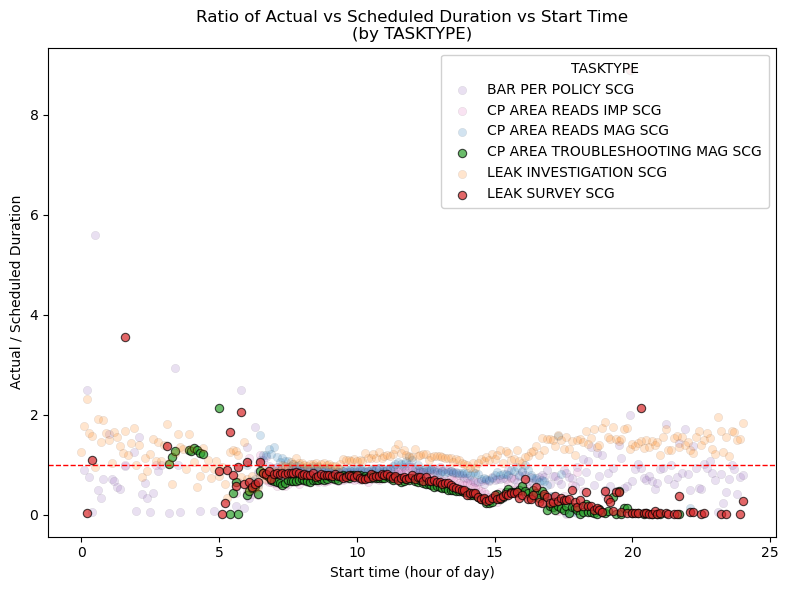

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import clean_dataframe



cols = [
    "TASKTYPE",
    "STARTTIME",
    "COMPLETIONTIMESTAMP",
    "SCHEDULEDSTART",
    "SCHEDULEDFINISH",
]
df = tasks_df[cols].copy()


time_cols = ["STARTTIME", "COMPLETIONTIMESTAMP", "SCHEDULEDSTART", "SCHEDULEDFINISH"]
for c in time_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")



# STARTTIME -> COMPLETIONTIMESTAMP
df["actual_total_hr"] = (df["COMPLETIONTIMESTAMP"] - df["STARTTIME"]).dt.total_seconds() / 3600

# 计划时长：SCHEDULEDSTART -> SCHEDULEDFINISH
df["scheduled_hr"] = (df["SCHEDULEDFINISH"] - df["SCHEDULEDSTART"]).dt.total_seconds() / 3600

# ratio = actual / scheduled
df["ratio_actual_sched"] = df["actual_total_hr"] / df["scheduled_hr"]

# 基础 sanity：必须是正的、有意义的值
df = df[
    (df["actual_total_hr"]   > 0) &
    (df["scheduled_hr"]      > 0) &
    np.isfinite(df["ratio_actual_sched"])
].copy()


df["start_hour"] = df["STARTTIME"].dt.hour + df["STARTTIME"].dt.minute / 60.0


angle = 2 * np.pi * df["start_hour"] / 24.0
df["start_sin"] = np.sin(angle)
df["start_cos"] = np.cos(angle)



cleaned = clean_dataframe(
    df=df,
    dropna_cols=["TASKTYPE", "start_hour", "ratio_actual_sched"],
    outlier_rules={"actual_total_hr": (0.05, 0.95),"scheduled_hr": (0.05, 0.95)}, 
    quantile_mode=True,
)


tasktype_counts = (
    cleaned.groupby("TASKTYPE")["ratio_actual_sched"]
    .size()
    .reset_index(name="n")
)
top_n = 6  
top_types = (
    tasktype_counts.sort_values("n", ascending=False)
    .head(top_n)["TASKTYPE"]
    .tolist()
)

plot_df = cleaned[cleaned["TASKTYPE"].isin(top_types)].copy()


plot_df["start_hour_bin"] = plot_df["start_hour"].round(1) 

agg = (
    plot_df
    .groupby(["TASKTYPE", "start_hour_bin"], as_index=False)["ratio_actual_sched"]
    .mean()
)



highlight_task = ["LEAK SURVEY SCG", "CP AREA TROUBLESHOOTING MAG SCG"]  

plt.figure(figsize=(8, 6))
base_palette = sns.color_palette(n_colors=max(10, len(top_types)))

colors = [c for i, c in enumerate(base_palette) if i != 5][:len(top_types)]
color_map = dict(zip(top_types, colors))
for t, sub in agg.groupby("TASKTYPE"):
    sub = sub.sort_values("start_hour_bin")

    alpha = 0.7 if t in highlight_task else 0.2
    lw    = 0.8 if t in highlight_task else 0.2
    marker_size = 40 if t in highlight_task else 20

    sns.scatterplot(
        data=sub,
        x="start_hour_bin",
        y="ratio_actual_sched",
        marker="o",
        linewidth=lw,
        alpha=alpha,
        edgecolor="black",
        color = color_map.get(t),
        label=t,
    )

plt.axhline(1.0, color="red", linestyle="--", linewidth=1)  
plt.xlabel("Start time (hour of day)")
plt.ylabel("Actual / Scheduled Duration")
plt.title("Ratio of Actual vs Scheduled Duration vs Start Time\n(by TASKTYPE)")

plt.legend(
    title="TASKTYPE",
    loc="upper right",     
    frameon=True,           
    framealpha=0.9,         
    borderpad=0.5
)

plt.tight_layout()
plt.show()



[NaN] Dropped 0 rows with NaN in ['TASKTYPE', 'start_hour', 'ratio_actual_sched']
[Outlier] actual_total_hr: kept in range (0.016, 5.873), removed 401366 rows.
[Outlier] scheduled_hr: kept in range (0.167, 6.000), removed 348993 rows.


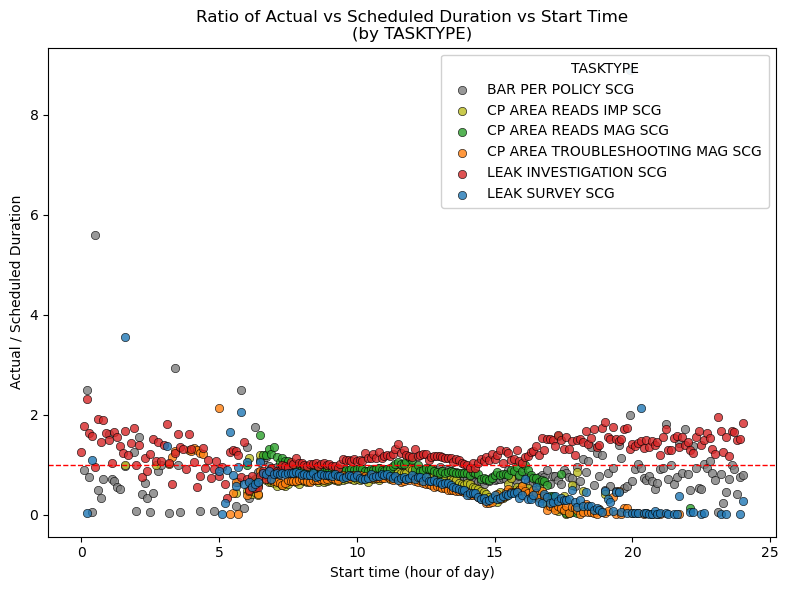

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import clean_dataframe



cols = [
    "TASKTYPE",
    "STARTTIME",
    "COMPLETIONTIMESTAMP",
    "SCHEDULEDSTART",
    "SCHEDULEDFINISH",
]
df = tasks_df[cols].copy()

# 转成 datetime
time_cols = ["STARTTIME", "COMPLETIONTIMESTAMP", "SCHEDULEDSTART", "SCHEDULEDFINISH"]
for c in time_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# ==================  actual / scheduled duration & ratio ==================


df["actual_total_hr"] = (df["COMPLETIONTIMESTAMP"] - df["STARTTIME"]).dt.total_seconds() / 3600


df["scheduled_hr"] = (df["SCHEDULEDFINISH"] - df["SCHEDULEDSTART"]).dt.total_seconds() / 3600


df["ratio_actual_sched"] = df["actual_total_hr"] / df["scheduled_hr"]


df = df[
    (df["actual_total_hr"]   > 0) &
    (df["scheduled_hr"]      > 0) &
    np.isfinite(df["ratio_actual_sched"])
].copy()


df["start_hour"] = df["STARTTIME"].dt.hour + df["STARTTIME"].dt.minute / 60.0


angle = 2 * np.pi * df["start_hour"] / 24.0
df["start_sin"] = np.sin(angle)
df["start_cos"] = np.cos(angle)



cleaned = clean_dataframe(
    df=df,
    dropna_cols=["TASKTYPE", "start_hour", "ratio_actual_sched"],
    outlier_rules={"actual_total_hr": (0.05, 0.95),"scheduled_hr": (0.05, 0.95)},  
)

tasktype_counts = (
    cleaned.groupby("TASKTYPE")["ratio_actual_sched"]
    .size()
    .reset_index(name="n")
)
top_n = 6  #
top_types = (
    tasktype_counts.sort_values("n", ascending=False)
    .head(top_n)["TASKTYPE"]
    .tolist()
)

plot_df = cleaned[cleaned["TASKTYPE"].isin(top_types)].copy()

# 
plot_df["start_hour_bin"] = plot_df["start_hour"].round(1)  

agg = (
    plot_df
    .groupby(["TASKTYPE", "start_hour_bin"], as_index=False)["ratio_actual_sched"]
    .mean()
)



highlight_task = ["LEAK SURVEY SCG", "CP AREA TROUBLESHOOTING MAG SCG"]   #
highlight_set = set([])

plt.figure(figsize=(8, 6))
base_palette = sns.color_palette("tab10", n_colors=10)


other_indices = [2, 3, 4, 6, 7, 8, 9]
colors = [base_palette[i] for i in other_indices][:len(top_types)]
color_map = dict(zip(top_types, colors))

for t, sub in agg.groupby("TASKTYPE"):
    sub = sub.sort_values("start_hour_bin")

    alpha = 0.8 if t not in highlight_set else 0.2
    lw    = 0.5 if t not in highlight_set else 0.2
    marker_size = 30 if t not in highlight_set else 20  


    if t == highlight_task[0]:
        color = "tab:blue"
    elif t == highlight_task[1]:
        color = "tab:orange"
    else:
        color = color_map.get(t)

    sns.scatterplot(
        data=sub,
        x="start_hour_bin",
        y="ratio_actual_sched",
        marker="o",
        linewidth=lw,
        alpha=alpha,
        edgecolor="black",
        color=color,
        label=t,
    )

plt.axhline(1.0, color="red", linestyle="--", linewidth=1)  # 1 = 实际 == 计划
plt.xlabel("Start time (hour of day)")
plt.ylabel("Actual / Scheduled Duration")
plt.title("Ratio of Actual vs Scheduled Duration vs Start Time\n(by TASKTYPE)")


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

leg = plt.legend(
    handles,
    labels,
    title="TASKTYPE",
    loc="upper right",      
    frameon=True,           
    framealpha=0.9,        
    borderpad=0.5,
)

# label_to_handle = dict(zip(labels, handles))

# for text in leg.get_texts():
#     label = text.get_text()
#     handle = label_to_handle.get(label)

#     if label in highlight_set:
#         text.set_alpha(1.0)
#         if handle is not None:
#             handle.set_alpha(1.0)
#     else:
#         text.set_alpha(0.3)
#         if handle is not None:
#             handle.set_alpha(0.3)

plt.tight_layout()
plt.show()


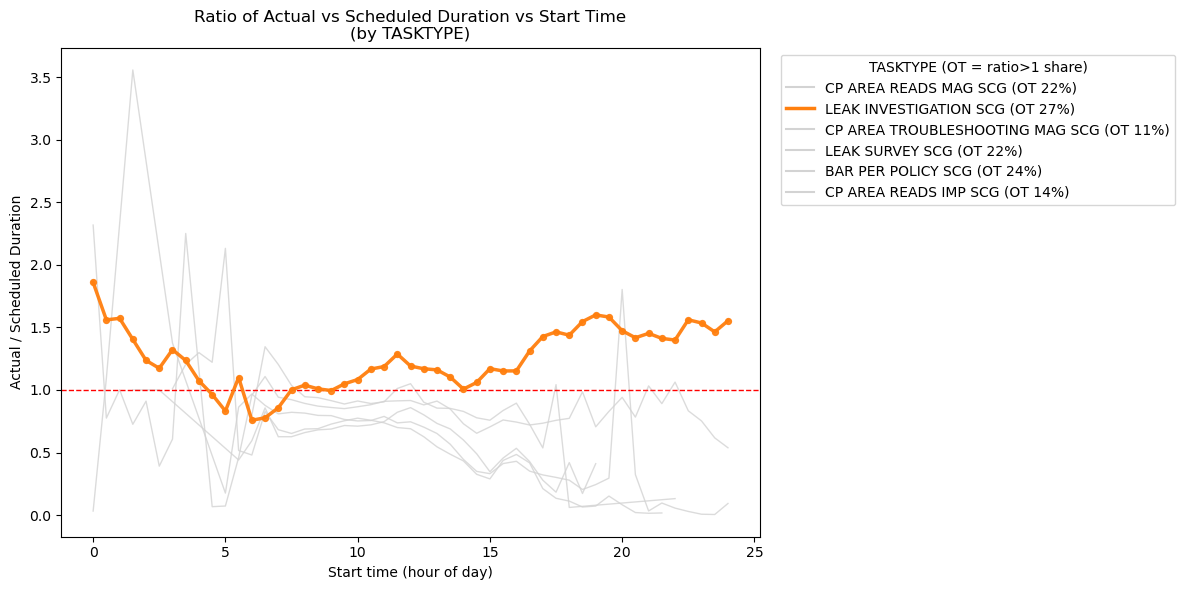

In [ ]:

tasktype_counts = (
    cleaned.groupby("TASKTYPE")["ratio_actual_sched"]
    .size()
    .reset_index(name="n")
)
top_n = 6
top_types = (
    tasktype_counts.sort_values("n", ascending=False)
    .head(top_n)["TASKTYPE"]
    .tolist()
)

plot_df = cleaned[cleaned["TASKTYPE"].isin(top_types)].copy()

plot_df["start_hour_bin"] = (plot_df["start_hour"] * 2).round() / 2.0  # 0.5 小时一格

agg = (
    plot_df
    .groupby(["TASKTYPE", "start_hour_bin"], as_index=False)["ratio_actual_sched"]
    .mean()
    .rename(columns={"ratio_actual_sched": "ratio_mean"}) 
)


ot_stats = (
    plot_df
    .groupby("TASKTYPE")["ratio_actual_sched"]
    .apply(lambda s: (s > 1).mean())
    .reset_index(name="overtime_rate")
)
ot_map = dict(zip(ot_stats["TASKTYPE"], ot_stats["overtime_rate"]))


highlight_task = "LEAK INVESTIGATION SCG" 

plt.figure(figsize=(12, 6))


for t, sub in agg.groupby("TASKTYPE"):
    sub = sub.sort_values("start_hour_bin")

    if t == highlight_task:
        continue 

    plt.plot(
        sub["start_hour_bin"],
        sub["ratio_mean"],
        color="lightgray",
        linewidth=1.0,
        alpha=0.8,
        zorder=1,
    )


if highlight_task in agg["TASKTYPE"].unique():
    sub_h = agg[agg["TASKTYPE"] == highlight_task].sort_values("start_hour_bin")

    plt.plot(
        sub_h["start_hour_bin"],
        sub_h["ratio_mean"],
        color="#FF7F0E",      
        linewidth=2.5,
        alpha=0.95,
        zorder=3,
    )
    plt.scatter(
        sub_h["start_hour_bin"],
        sub_h["ratio_mean"],
        s=18,
        color="#FF7F0E",
        alpha=0.9,
        zorder=4,
    )

plt.axhline(1.0, color="red", linestyle="--", linewidth=1)

plt.xlabel("Start time (hour of day)")
plt.ylabel("Actual / Scheduled Duration")
plt.title("Ratio of Actual vs Scheduled Duration vs Start Time\n(by TASKTYPE)")



handles = []
labels = []
for t in top_types:
    ot = ot_map.get(t, np.nan)
    label = f"{t} (OT {ot:.0%})" if not np.isnan(ot) else t

    if t == highlight_task:
        line = plt.Line2D(
            [0], [0],
            color="#FF7F0E",
            linewidth=2.5,
        )
    else:
        line = plt.Line2D(
            [0], [0],
            color="lightgray",
            linewidth=1.5,
        )
    handles.append(line)
    labels.append(label)

plt.legend(
    handles,
    labels,
    title="TASKTYPE (OT = ratio>1 share)",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)
plt.tight_layout()
plt.show()



[NaN] Dropped 0 rows with NaN in ['TASKTYPE', 'start_hour', 'actual_total_hr']
[Outlier] actual_total_hr: kept in range (0.016, 5.873), removed 401375 rows.
[Skip] Column 'scheduled_hr' not found in DataFrame.


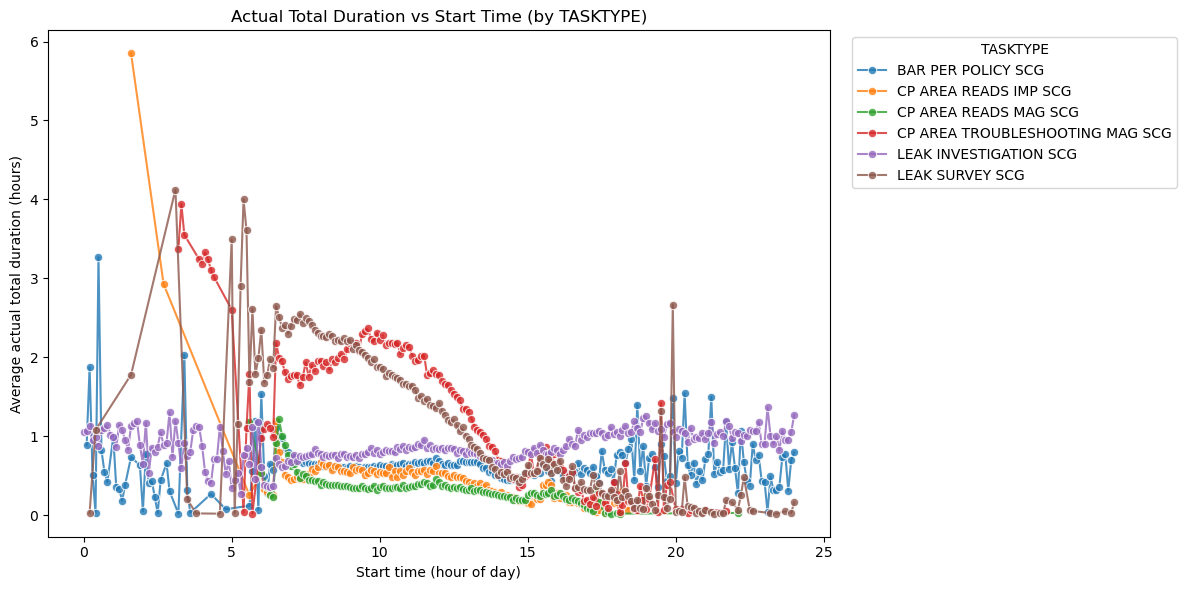

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import clean_dataframe


cols = [
    "TASKTYPE",
    "STARTTIME",
    "COMPLETIONTIMESTAMP",
]
df = tasks_df[cols].copy()


df["STARTTIME"] = pd.to_datetime(df["STARTTIME"], errors="coerce")
df["COMPLETIONTIMESTAMP"] = pd.to_datetime(df["COMPLETIONTIMESTAMP"], errors="coerce")



# STARTTIME -> COMPLETIONTIMESTAMP
df["actual_total_hr"] = (
    df["COMPLETIONTIMESTAMP"] - df["STARTTIME"]
).dt.total_seconds() / 3600

# 只保留 >0 的正常任务
df = df[df["actual_total_hr"] > 0].copy()



df["start_hour"] = df["STARTTIME"].dt.hour + df["STARTTIME"].dt.minute / 60.0

angle = 2 * np.pi * df["start_hour"] / 24.0
df["start_sin"] = np.sin(angle)
df["start_cos"] = np.cos(angle)



cleaned = clean_dataframe(
    df=df,
    dropna_cols=["TASKTYPE", "start_hour", "actual_total_hr"],
    outlier_rules={"actual_total_hr": (0.05, 0.95),"scheduled_hr": (0.05, 0.95)},  # 保留中间 96% 的时长
    quantile_mode=True,
)



tasktype_counts = (
    cleaned.groupby("TASKTYPE")["actual_total_hr"]
    .size()
    .reset_index(name="n")
)

TOP_N = 6
top_types = (
    tasktype_counts.sort_values("n", ascending=False)
    .head(TOP_N)["TASKTYPE"]
    .tolist()
)

plot_df = cleaned[cleaned["TASKTYPE"].isin(top_types)].copy()

# 为了线条别太抖，对 start_hour 做一点 bin（比如 0.5 小时粒度）
plot_df["start_hour_bin"] = plot_df["start_hour"].round(1)

agg = (
    plot_df
    .groupby(["TASKTYPE", "start_hour_bin"], as_index=False)["actual_total_hr"]
    .mean()
)



plt.figure(figsize=(12, 6))
sns.lineplot(
    data=agg,
    x="start_hour_bin",
    y="actual_total_hr",
    hue="TASKTYPE",
    marker="o",
    alpha=0.8,
)

plt.xlabel("Start time (hour of day)")
plt.ylabel("Average actual total duration (hours)")
plt.title("Actual Total Duration vs Start Time (by TASKTYPE)")
plt.legend(title="TASKTYPE", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


[NaN] Dropped 1289499 rows with NaN in ['TASKTYPE', 'start_hour', 'scheduled_hr']
[Skip] Column 'actual_total_hr' not found in DataFrame.
[Outlier] scheduled_hr: kept in range (0.147, 14.200), removed 428361 rows.


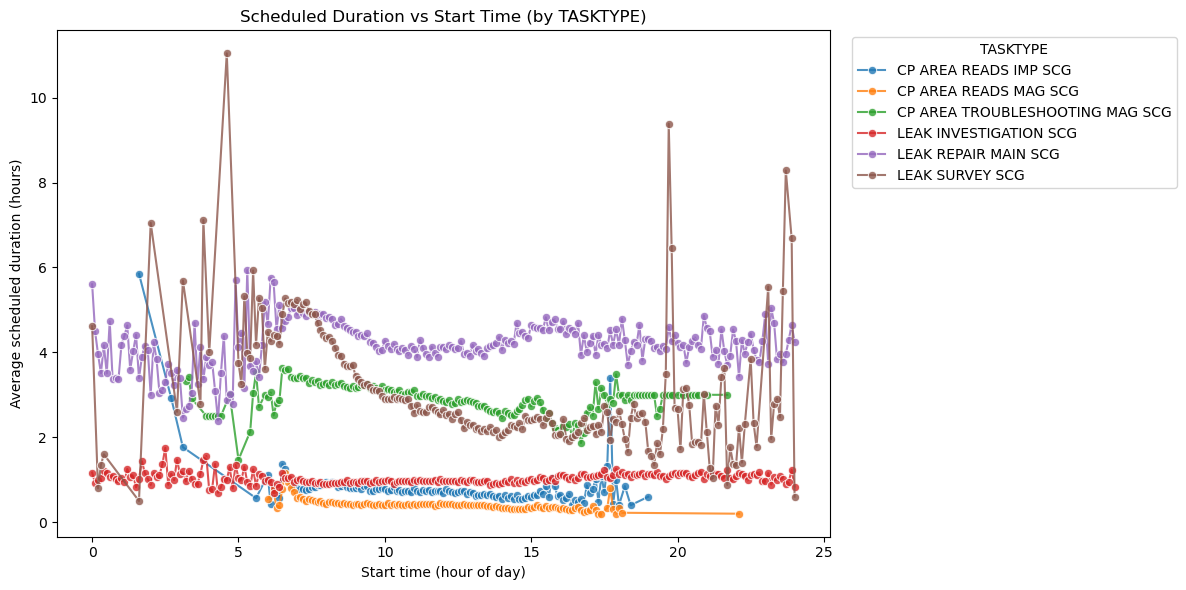

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import clean_dataframe



cols = [
    "TASKTYPE",
    "STARTTIME",
    "SCHEDULEDSTART",
    "SCHEDULEDFINISH",
]
df = tasks_df[cols].copy()

# 时间转 datetime
for c in ["STARTTIME", "SCHEDULEDSTART", "SCHEDULEDFINISH"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")



# SCHEDULEDSTART -> SCHEDULEDFINISH（小时）
df["scheduled_hr"] = (
    df["SCHEDULEDFINISH"] - df["SCHEDULEDSTART"]
).dt.total_seconds() / 3600


df = df[df["scheduled_hr"] > 0].copy()



df["start_hour"] = df["STARTTIME"].dt.hour + df["STARTTIME"].dt.minute / 60.0

angle = 2 * np.pi * df["start_hour"] / 24.0
df["start_sin"] = np.sin(angle)
df["start_cos"] = np.cos(angle)



cleaned = clean_dataframe(
    df=df,
    dropna_cols=["TASKTYPE", "start_hour", "scheduled_hr"],
    outlier_rules={"actual_total_hr": (0.05, 0.95),"scheduled_hr": (0.05, 0.95)},  
    quantile_mode=True,
)


tasktype_counts = (
    cleaned.groupby("TASKTYPE")["scheduled_hr"]
    .size()
    .reset_index(name="n")
)

TOP_N = 6
top_types = (
    tasktype_counts.sort_values("n", ascending=False)
    .head(TOP_N)["TASKTYPE"]
    .tolist()
)

plot_df = cleaned[cleaned["TASKTYPE"].isin(top_types)].copy()


plot_df["start_hour_bin"] = plot_df["start_hour"].round(1)

agg = (
    plot_df
    .groupby(["TASKTYPE", "start_hour_bin"], as_index=False)["scheduled_hr"]
    .mean()
)



plt.figure(figsize=(12, 6))
sns.lineplot(
    data=agg,
    x="start_hour_bin",
    y="scheduled_hr",
    hue="TASKTYPE",
    marker="o",
    alpha=0.8,
)

plt.xlabel("Start time (hour of day)")
plt.ylabel("Average scheduled duration (hours)")
plt.title("Scheduled Duration vs Start Time (by TASKTYPE)")
plt.legend(title="TASKTYPE", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
